<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211025_keras_two_layer_logistc_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2層からなるニューラルネットワークの実装
20211023_keras_logistic_regression.ipynbでは1層からなるニューラルネットワークの実装を行いました。イメージとしては(x1, x2)平面に直線を１本ひき2つに別れた領域のどちらに属するか、というイメージです。

ここでは(x1, x2)平面に直線を2本ひき4つに別れた領域のどれに別れたか、と言うことを確認します。
また本当にそのような結果になるのかといった部分も確認します

## ライブラリのインポート

In [28]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils

np.random.seed(20211025)
tf.random.set_seed(20211025)

## 学習用のデータ生成

In [29]:
def generate_datablock(n, mu, var, t):
  data = multivariate_normal(mu, np.eye(2)*var, n)
  df = DataFrame(data, columns=['x1', 'x2'])
  df['t'] = t
  return df

df0 = generate_datablock(15, [-8, -8], 22, 0)
df1 = generate_datablock(15, [7, -8], 22, 0)
df2 = generate_datablock(10, [-8, 7], 22, 0)
df3 = generate_datablock(20, [5, 5], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [30]:
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values

In [31]:
train_x

array([[ 1.00101277e+01,  2.57391635e+00],
       [ 4.94484902e+00,  7.91182137e+00],
       [ 1.18014244e+01,  6.27617731e+00],
       [-1.27834230e+00,  7.34766560e+00],
       [ 3.08381323e-01,  1.11763409e+01],
       [-1.39098773e+01, -1.00684792e+01],
       [ 5.15833760e+00, -1.34968486e+01],
       [-8.17787909e+00,  9.55018598e+00],
       [ 3.27916689e-01, -1.98474677e+01],
       [ 1.53271668e+01,  7.58999399e+00],
       [ 2.99325176e+00,  2.33875064e+00],
       [ 5.27129983e+00, -8.22702326e+00],
       [-9.03500290e+00, -1.02569589e+01],
       [ 9.93959442e+00, -4.54828178e+00],
       [ 5.57372184e+00, -7.22112968e+00],
       [-3.25912582e+00,  3.29803136e+00],
       [-1.88861708e+00, -8.96294289e+00],
       [ 6.36490463e+00,  3.82450323e+00],
       [ 1.19157055e+01, -4.98495839e+00],
       [-1.52343355e+01, -7.31739161e+00],
       [ 2.52668631e-01, -9.19977345e+00],
       [ 1.23087649e+01, -1.37573888e+01],
       [ 3.75827267e+00,  3.13345304e-02],
       [-5.

## ニューラルネットワークのモデル定義

In [32]:
model = models.Sequential()
model.add(layers.Dense(10, activation='tanh', input_shape=(2, ), name='hidden'))
model.add(layers.Dense(1, activation='sigmoid', name='output'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


`model.add()`によりレイヤーを追加することができます。
2つ目のレイヤーでは`input_shape`を定義していませんが、1つ目のレイヤーの出力がそのまま入力となります。よってここでは入力値の形状は(None, 2)で内容は下記(z1, z2)となります。

$$
z_{1} = tanh(w_{11}x_{1} + w_{21}x_{2} + b_{1})
$$
$$
z_{2} = tanh(w_{12}x_{1} + w_{22}x_{2} + b_{2})
$$


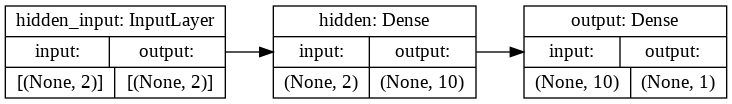

In [33]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True, dpi=96)

hidden: Denseのoutputを増やすことで平面を分割する直線を増やすことができます。これにより格領域を特徴づける変数を増やすことができます。

## 最適化アルゴリズムと誤差関数の定義

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## 学習

In [35]:
history = model.fit(train_x, train_t, batch_size=len(train_set), epochs=5000, verbose=0)

## 学習結果の可視化

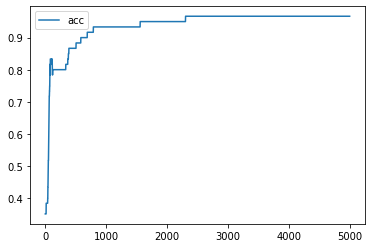

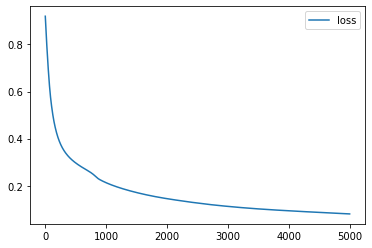

In [36]:
DataFrame({'acc': history.history['acc']}).plot()
DataFrame({'loss': history.history['loss']}).plot()

## 得られた結果の図

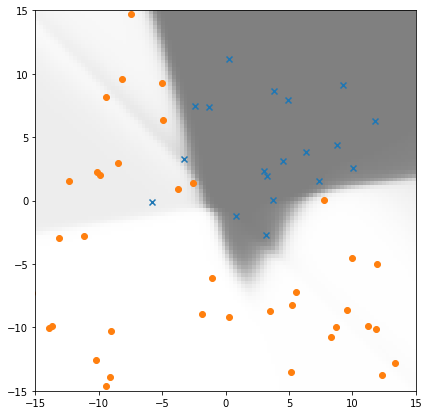

In [37]:
train_set1 = train_set[train_set['t'] == 1]
train_set2 = train_set[train_set['t'] == 0]

fig = plt.figure(figsize=(10, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([-15, 15])
subplot.set_xlim([-15, 15])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = [[x1, x2] for x2 in np.linspace(-15, 15, 100) for x1 in np.linspace(-15, 15, 100)]
p_vals = model.predict(np.array(locations)).reshape((100, 100))

subplot.imshow(p_vals, origin='lower', extent=(-15, 15, -15, 15), vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.5)